In [1]:
import flax
import dill as pickle
import builtins
from jax._src.lib import xla_client
import tensorflow as tf
import argparse
import math
import os
import jax
import jax.numpy as jnp
from jax import random, jit, grad, vmap
from jax.example_libraries.optimizers import adam
from functools import partial
from flax.training.common_utils import shard
from tqdm import tqdm
from PIL import Image
import numpy as np
from functools import partial
from flax.training.common_utils import shard
import transformers

2023-03-29 09:37:31.207144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib


In [53]:
builtins.bfloat16 = xla_client.bfloat16
def pickle_load(filename):
    """ Wrapper to load an object from a file."""
    with tf.io.gfile.GFile(filename, 'rb') as f:
        pickled = pickle.loads(f.read())
    return pickled
# model=pickle_load("/home/beich/majesty/project/models/food-512.pkl")
model=pickle_load("/home/beich/majesty/project/WISE1-40000_best.pickle")

G=model['state_G']

processor=transformers.CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

In [18]:
class CLIPLoss(flax.linen.Module):

    def __init__(self, opts):
        self.processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.model = transformers.FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.upsample = jax.image.resize
        self.avg_pool = partial(flax.linen.avg_pool, window_shape=(opts.stylegan_size // 32, opts.stylegan_size // 32, ))
        self.rng = random.PRNGKey(0)

    def __call__(self, image, text_id,text_mask):
        upsampled_image = self.upsample(image, (image.shape[0], 224, 224, image.shape[-1]), "bilinear")
        pooled_image = self.avg_pool(upsampled_image)
        inputs = self.processor(images=pooled_image,  return_tensors="jax", do_center_crop=False,do_rescale=False)
#         inputs = shard(inputs)
#         input_image= jnp.expand_dims(jnp.mean(inputs["pixel_values"], axis=0), axis=0)

#         input_image= jnp.mean(inputs["pixel_values"], axis=0)
        result = self.model(input_ids=text_id,attention_mask =text_mask,pixel_values=inputs["pixel_values"])
        similarity = 1 - result["logits_per_image"][0][0] / 100
        return similarity

In [6]:
def get_lr(t, initial_lr, rampdown=0.25, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)
    return initial_lr * lr_ramp


def generator_mean_latent(generator, n_latent, rng):
    latent_in = random.normal(rng, (n_latent, 512))

    latent = generator.apply_mapping({'params': G.params['mapping'], 'moving_stats': G.moving_stats},latent_in,c=jnp.array([[0,0,0,0,1],[0,0,0,0,1]]),train=False).mean(0, keepdims=True)
    return latent



In [56]:
img_orig=None

def main(args):
    truncation_psi=args.truncation_psi
    text_inputs = processor(args.description, return_tensors="jax")
    os.makedirs(args.results_dir, exist_ok=True)

    rng = jax.random.PRNGKey(100)
#     g_ema = Generator(args.stylegan_size, 512, 8)
#     g_ema.load_weights(args.ckpt)
#     g_ema.eval()

    mean_latent = generator_mean_latent(G, 2, rng)
    latent_code_init = jnp.repeat(mean_latent, 2, axis=0)
    global img_orig

    img_orig = G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},latent_code_init, noise_mode='none')

    latent = jnp.array(latent_code_init, dtype=jnp.float32)
    clip_loss = CLIPLoss(args)

    # Initialize Adam optimizer with learning rate and latent as parameters
    optimizer_init, optimizer_update, get_params = adam(args.lr)
    optimizer_state = optimizer_init(latent)

    @jit
    def update(rng, t, optimizer_state, text_id,text_mask):
        latent = get_params(optimizer_state)
        img_gen =  G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},truncation_psi * latent + (1 - truncation_psi) * mean_w_values , noise_mode='none')
        similarity = clip_loss((img_gen+1)/2, text_id,text_mask)
        loss = jnp.mean(similarity)
        g = grad(lambda l: jnp.mean(clip_loss((G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},l, noise_mode='none')+1)/2
            , text_id,text_mask)))(latent)
        optimizer_state = optimizer_update(t, g, optimizer_state)
        return rng, optimizer_state, loss

    pbar = tqdm(range(args.step))
    for i in pbar:
        t = i / args.step
        lr = get_lr(t, args.lr)
        rng, optimizer_state, loss = update(rng, i, optimizer_state, text_inputs['input_ids'],text_inputs['attention_mask'])
        print(f"{loss.item():.4f}")
        pbar.set_description(f"loss: {loss.item():.4f};")
        if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
            img_gen=G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},get_params(optimizer_state), noise_mode='none')
            img_np = np.array((img_gen[0]
                .clip(-1, 1) * 127.5 + 127.5).astype(np.uint8))
            img = Image.fromarray(img_np, mode="RGB")
            img.save(f"{args.results_dir}/{str(i).zfill(5)}.jpg")

    img_gen=G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},get_params(optimizer_state), noise_mode='none')

    img_np = np.array((img_gen[0].clip(-1, 1) * 127.5 + 127.5).astype(np.uint8))
    img = Image.fromarray(img_np, mode="RGB")
    img.save(os.path.join(args.results_dir, "final_result.jpg"))


class Args:
    def __init__(
        self,
        description="a person with purple hair",
        lr_rampup=0.05,
        lr=0.1,stylegan_size=512,
        step=300,
        save_intermediate_image_every=20,
        results_dir="results",
        truncation_psi=0.7
    ):
        self.description = description
        self.lr_rampup = lr_rampup
        self.lr = lr
        self.stylegan_size=stylegan_size
        self.step = step
        self.save_intermediate_image_every = save_intermediate_image_every
        self.results_dir = results_dir
        self.truncation_psi=truncation_psi

# Replace the argparse lines with the following code
args = Args(
    description="short blur t-shirt with red short pants",
    lr_rampup=0.05,
    lr=3e-3,
    step=300,stylegan_size=512,
    save_intermediate_image_every=10,
    results_dir="results",
    truncation_psi=0.7
)
result_image = main(args)


loss: 0.7778;:   0%|                                                                                                                                       | 0/300 [01:30<?, ?it/s]

0.7778


loss: 0.7765;:   1%|█▎                                                                                                                           | 3/300 [01:30<1:41:04, 20.42s/it]

0.7770
0.7765


loss: 0.7742;:   2%|██                                                                                                                             | 5/300 [01:31<39:23,  8.01s/it]

0.7753
0.7742


loss: 0.7722;:   2%|██▉                                                                                                                            | 7/300 [01:31<17:51,  3.66s/it]

0.7730
0.7722


loss: 0.7702;:   3%|███▊                                                                                                                           | 9/300 [01:32<08:46,  1.81s/it]

0.7709
0.7702


loss: 0.7672;:   3%|████▏                                                                                                                         | 10/300 [01:32<06:18,  1.31s/it]

0.7686
0.7672


loss: 0.7653;:   4%|█████▍                                                                                                                        | 13/300 [01:33<02:56,  1.62it/s]

0.7666
0.7653


loss: 0.7648;:   5%|██████▎                                                                                                                       | 15/300 [01:33<01:51,  2.55it/s]

0.7652
0.7648


loss: 0.7645;:   6%|███████▏                                                                                                                      | 17/300 [01:33<01:20,  3.53it/s]

0.7645
0.7645


loss: 0.7642;:   6%|███████▉                                                                                                                      | 19/300 [01:34<01:04,  4.35it/s]

0.7642
0.7642


loss: 0.7640;:   7%|████████▍                                                                                                                     | 20/300 [01:34<01:00,  4.65it/s]

0.7643
0.7640


loss: 0.7637;:   8%|█████████▋                                                                                                                    | 23/300 [01:35<01:10,  3.94it/s]

0.7633
0.7637


loss: 0.7634;:   8%|██████████▌                                                                                                                   | 25/300 [01:35<00:59,  4.63it/s]

0.7634
0.7634


loss: 0.7624;:   9%|███████████▎                                                                                                                  | 27/300 [01:36<00:53,  5.07it/s]

0.7629
0.7624


loss: 0.7628;:  10%|████████████▏                                                                                                                 | 29/300 [01:36<00:51,  5.31it/s]

0.7630
0.7628


loss: 0.7620;:  10%|████████████▌                                                                                                                 | 30/300 [01:36<00:50,  5.39it/s]

0.7627
0.7620


loss: 0.7608;:  11%|█████████████▊                                                                                                                | 33/300 [01:37<01:03,  4.18it/s]

0.7613
0.7608


loss: 0.7613;:  12%|██████████████▋                                                                                                               | 35/300 [01:37<00:55,  4.79it/s]

0.7614
0.7613


loss: 0.7603;:  12%|███████████████▌                                                                                                              | 37/300 [01:38<00:50,  5.16it/s]

0.7609
0.7603


loss: 0.7586;:  13%|████████████████▍                                                                                                             | 39/300 [01:38<00:48,  5.36it/s]

0.7597
0.7586


loss: 0.7569;:  13%|████████████████▊                                                                                                             | 40/300 [01:39<00:47,  5.42it/s]

0.7574
0.7569


loss: 0.7552;:  14%|██████████████████                                                                                                            | 43/300 [01:39<01:00,  4.23it/s]

0.7553
0.7552


loss: 0.7543;:  15%|██████████████████▉                                                                                                           | 45/300 [01:40<00:52,  4.82it/s]

0.7551
0.7543


loss: 0.7536;:  16%|███████████████████▋                                                                                                          | 47/300 [01:40<00:48,  5.19it/s]

0.7537
0.7536


loss: 0.7523;:  16%|████████████████████▌                                                                                                         | 49/300 [01:40<00:46,  5.38it/s]

0.7532
0.7523


loss: 0.7518;:  17%|█████████████████████                                                                                                         | 50/300 [01:41<00:45,  5.44it/s]

0.7516
0.7518


loss: 0.7501;:  18%|██████████████████████▎                                                                                                       | 53/300 [01:41<00:58,  4.22it/s]

0.7507
0.7501


loss: 0.7496;:  18%|███████████████████████                                                                                                       | 55/300 [01:42<00:50,  4.82it/s]

0.7504
0.7496


loss: 0.7488;:  19%|███████████████████████▉                                                                                                      | 57/300 [01:42<00:46,  5.18it/s]

0.7498
0.7488


loss: 0.7485;:  20%|████████████████████████▊                                                                                                     | 59/300 [01:43<00:44,  5.38it/s]

0.7489
0.7485


loss: 0.7473;:  20%|█████████████████████████▏                                                                                                    | 60/300 [01:43<00:44,  5.44it/s]

0.7478
0.7473


loss: 0.7456;:  21%|██████████████████████████▍                                                                                                   | 63/300 [01:44<00:56,  4.20it/s]

0.7468
0.7456


loss: 0.7445;:  22%|███████████████████████████▎                                                                                                  | 65/300 [01:44<00:48,  4.81it/s]

0.7452
0.7445


loss: 0.7425;:  22%|████████████████████████████▏                                                                                                 | 67/300 [01:44<00:45,  5.17it/s]

0.7438
0.7425


loss: 0.7406;:  23%|████████████████████████████▉                                                                                                 | 69/300 [01:45<00:42,  5.37it/s]

0.7424
0.7406


loss: 0.7406;:  23%|█████████████████████████████▍                                                                                                | 70/300 [01:45<00:42,  5.43it/s]

0.7402
0.7406


loss: 0.7384;:  24%|██████████████████████████████▋                                                                                               | 73/300 [01:46<00:54,  4.20it/s]

0.7390
0.7384


loss: 0.7374;:  25%|███████████████████████████████▌                                                                                              | 75/300 [01:46<00:46,  4.81it/s]

0.7380
0.7374


loss: 0.7362;:  26%|████████████████████████████████▎                                                                                             | 77/300 [01:47<00:43,  5.18it/s]

0.7365
0.7362


loss: 0.7344;:  26%|█████████████████████████████████▏                                                                                            | 79/300 [01:47<00:41,  5.38it/s]

0.7356
0.7344


loss: 0.7345;:  27%|█████████████████████████████████▌                                                                                            | 80/300 [01:47<00:40,  5.44it/s]

0.7339
0.7345


loss: 0.7336;:  28%|██████████████████████████████████▊                                                                                           | 83/300 [01:48<00:51,  4.20it/s]

0.7333
0.7336


loss: 0.7318;:  28%|███████████████████████████████████▋                                                                                          | 85/300 [01:48<00:44,  4.81it/s]

0.7330
0.7318


loss: 0.7306;:  29%|████████████████████████████████████▌                                                                                         | 87/300 [01:49<00:41,  5.18it/s]

0.7317
0.7306


loss: 0.7299;:  30%|█████████████████████████████████████▍                                                                                        | 89/300 [01:49<00:39,  5.37it/s]

0.7302
0.7299


loss: 0.7293;:  30%|█████████████████████████████████████▊                                                                                        | 90/300 [01:49<00:38,  5.44it/s]

0.7304
0.7293


loss: 0.7287;:  31%|███████████████████████████████████████                                                                                       | 93/300 [01:50<00:49,  4.16it/s]

0.7287
0.7287


loss: 0.7275;:  32%|███████████████████████████████████████▉                                                                                      | 95/300 [01:51<00:42,  4.78it/s]

0.7285
0.7275


loss: 0.7279;:  32%|████████████████████████████████████████▋                                                                                     | 97/300 [01:51<00:39,  5.16it/s]

0.7275
0.7279


loss: 0.7274;:  33%|█████████████████████████████████████████▌                                                                                    | 99/300 [01:51<00:37,  5.37it/s]

0.7275
0.7274


loss: 0.7264;:  33%|█████████████████████████████████████████▋                                                                                   | 100/300 [01:52<00:36,  5.43it/s]

0.7268
0.7264


loss: 0.7258;:  34%|██████████████████████████████████████████▉                                                                                  | 103/300 [01:52<00:46,  4.24it/s]

0.7266
0.7258


loss: 0.7256;:  35%|███████████████████████████████████████████▊                                                                                 | 105/300 [01:53<00:40,  4.83it/s]

0.7253
0.7256


loss: 0.7250;:  36%|████████████████████████████████████████████▌                                                                                | 107/300 [01:53<00:37,  5.19it/s]

0.7261
0.7250


loss: 0.7257;:  36%|█████████████████████████████████████████████▍                                                                               | 109/300 [01:53<00:35,  5.39it/s]

0.7255
0.7257


loss: 0.7259;:  37%|█████████████████████████████████████████████▊                                                                               | 110/300 [01:54<00:34,  5.44it/s]

0.7249
0.7259


loss: 0.7261;:  38%|███████████████████████████████████████████████                                                                              | 113/300 [01:55<00:44,  4.20it/s]

0.7263
0.7261


loss: 0.7266;:  38%|███████████████████████████████████████████████▉                                                                             | 115/300 [01:55<00:38,  4.80it/s]

0.7256
0.7266


loss: 0.7261;:  39%|████████████████████████████████████████████████▊                                                                            | 117/300 [01:55<00:35,  5.17it/s]

0.7259
0.7261


loss: 0.7257;:  40%|█████████████████████████████████████████████████▌                                                                           | 119/300 [01:56<00:33,  5.37it/s]

0.7255
0.7257


loss: 0.7252;:  40%|██████████████████████████████████████████████████                                                                           | 120/300 [01:56<00:33,  5.43it/s]

0.7246
0.7252


loss: 0.7245;:  41%|███████████████████████████████████████████████████▎                                                                         | 123/300 [01:57<00:42,  4.18it/s]

0.7243
0.7245


loss: 0.7237;:  42%|████████████████████████████████████████████████████                                                                         | 125/300 [01:57<00:36,  4.80it/s]

0.7241
0.7237


loss: 0.7239;:  42%|████████████████████████████████████████████████████▉                                                                        | 127/300 [01:57<00:33,  5.17it/s]

0.7244
0.7239


loss: 0.7238;:  43%|█████████████████████████████████████████████████████▊                                                                       | 129/300 [01:58<00:31,  5.37it/s]

0.7243
0.7238


loss: 0.7238;:  43%|██████████████████████████████████████████████████████▏                                                                      | 130/300 [01:58<00:31,  5.43it/s]

0.7246
0.7238


loss: 0.7238;:  44%|███████████████████████████████████████████████████████▍                                                                     | 133/300 [01:59<00:39,  4.19it/s]

0.7243
0.7238


loss: 0.7239;:  45%|████████████████████████████████████████████████████████▎                                                                    | 135/300 [01:59<00:34,  4.80it/s]

0.7242
0.7239


loss: 0.7241;:  46%|█████████████████████████████████████████████████████████                                                                    | 137/300 [02:00<00:31,  5.17it/s]

0.7248
0.7241


loss: 0.7239;:  46%|█████████████████████████████████████████████████████████▉                                                                   | 139/300 [02:00<00:29,  5.37it/s]

0.7239
0.7239


loss: 0.7233;:  47%|██████████████████████████████████████████████████████████▎                                                                  | 140/300 [02:00<00:29,  5.43it/s]

0.7240
0.7233


loss: 0.7226;:  48%|███████████████████████████████████████████████████████████▌                                                                 | 143/300 [02:01<00:37,  4.15it/s]

0.7227
0.7226


loss: 0.7223;:  48%|████████████████████████████████████████████████████████████▍                                                                | 145/300 [02:01<00:32,  4.77it/s]

0.7227
0.7223


loss: 0.7227;:  49%|█████████████████████████████████████████████████████████████▎                                                               | 147/300 [02:02<00:29,  5.15it/s]

0.7222
0.7227


loss: 0.7227;:  50%|██████████████████████████████████████████████████████████████                                                               | 149/300 [02:02<00:28,  5.36it/s]

0.7221
0.7227


loss: 0.7223;:  50%|██████████████████████████████████████████████████████████████▌                                                              | 150/300 [02:03<00:27,  5.42it/s]

0.7225
0.7223


loss: 0.7224;:  51%|███████████████████████████████████████████████████████████████▊                                                             | 153/300 [02:03<00:34,  4.21it/s]

0.7221
0.7224


loss: 0.7223;:  52%|████████████████████████████████████████████████████████████████▌                                                            | 155/300 [02:04<00:30,  4.82it/s]

0.7224
0.7223


loss: 0.7225;:  52%|█████████████████████████████████████████████████████████████████▍                                                           | 157/300 [02:04<00:27,  5.18it/s]

0.7228
0.7225


loss: 0.7231;:  53%|██████████████████████████████████████████████████████████████████▎                                                          | 159/300 [02:04<00:26,  5.38it/s]

0.7224
0.7231


loss: 0.7220;:  53%|██████████████████████████████████████████████████████████████████▋                                                          | 160/300 [02:05<00:25,  5.44it/s]

0.7229
0.7220


loss: 0.7219;:  54%|███████████████████████████████████████████████████████████████████▉                                                         | 163/300 [02:05<00:32,  4.16it/s]

0.7221
0.7219


loss: 0.7221;:  55%|████████████████████████████████████████████████████████████████████▊                                                        | 165/300 [02:06<00:28,  4.78it/s]

0.7216
0.7221


loss: 0.7219;:  56%|█████████████████████████████████████████████████████████████████████▌                                                       | 167/300 [02:06<00:25,  5.16it/s]

0.7219
0.7219


loss: 0.7214;:  56%|██████████████████████████████████████████████████████████████████████▍                                                      | 169/300 [02:07<00:24,  5.36it/s]

0.7219
0.7214


loss: 0.7224;:  57%|██████████████████████████████████████████████████████████████████████▊                                                      | 170/300 [02:07<00:23,  5.43it/s]

0.7220
0.7224


loss: 0.7221;:  58%|████████████████████████████████████████████████████████████████████████                                                     | 173/300 [02:08<00:30,  4.20it/s]

0.7222
0.7221


loss: 0.7224;:  58%|████████████████████████████████████████████████████████████████████████▉                                                    | 175/300 [02:08<00:26,  4.81it/s]

0.7222
0.7224


loss: 0.7222;:  59%|█████████████████████████████████████████████████████████████████████████▊                                                   | 177/300 [02:08<00:23,  5.18it/s]

0.7229
0.7222


loss: 0.7225;:  60%|██████████████████████████████████████████████████████████████████████████▌                                                  | 179/300 [02:09<00:22,  5.37it/s]

0.7224
0.7225


loss: 0.7221;:  60%|███████████████████████████████████████████████████████████████████████████                                                  | 180/300 [02:09<00:22,  5.43it/s]

0.7224
0.7221


loss: 0.7226;:  61%|████████████████████████████████████████████████████████████████████████████▎                                                | 183/300 [02:10<00:27,  4.21it/s]

0.7220
0.7226


loss: 0.7225;:  62%|█████████████████████████████████████████████████████████████████████████████                                                | 185/300 [02:10<00:23,  4.81it/s]

0.7225
0.7225


loss: 0.7231;:  62%|█████████████████████████████████████████████████████████████████████████████▉                                               | 187/300 [02:11<00:21,  5.18it/s]

0.7230
0.7231


loss: 0.7217;:  63%|██████████████████████████████████████████████████████████████████████████████▊                                              | 189/300 [02:11<00:20,  5.38it/s]

0.7230
0.7217


loss: 0.7231;:  63%|███████████████████████████████████████████████████████████████████████████████▏                                             | 190/300 [02:11<00:20,  5.43it/s]

0.7218
0.7231


loss: 0.7220;:  64%|████████████████████████████████████████████████████████████████████████████████▍                                            | 193/300 [02:12<00:25,  4.23it/s]

0.7222
0.7220


loss: 0.7233;:  65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 195/300 [02:12<00:21,  4.82it/s]

0.7222
0.7233


loss: 0.7236;:  66%|██████████████████████████████████████████████████████████████████████████████████                                           | 197/300 [02:13<00:19,  5.18it/s]

0.7225
0.7236


loss: 0.7240;:  66%|██████████████████████████████████████████████████████████████████████████████████▉                                          | 199/300 [02:13<00:18,  5.38it/s]

0.7233
0.7240


loss: 0.7239;:  67%|███████████████████████████████████████████████████████████████████████████████████▎                                         | 200/300 [02:13<00:18,  5.44it/s]

0.7230
0.7239


loss: 0.7245;:  68%|████████████████████████████████████████████████████████████████████████████████████▌                                        | 203/300 [02:14<00:22,  4.22it/s]

0.7249
0.7245


loss: 0.7261;:  68%|█████████████████████████████████████████████████████████████████████████████████████▍                                       | 205/300 [02:15<00:19,  4.81it/s]

0.7257
0.7261


loss: 0.7254;:  69%|██████████████████████████████████████████████████████████████████████████████████████▎                                      | 207/300 [02:15<00:17,  5.18it/s]

0.7260
0.7254


loss: 0.7253;:  70%|███████████████████████████████████████████████████████████████████████████████████████                                      | 209/300 [02:15<00:16,  5.38it/s]

0.7263
0.7253


loss: 0.7257;:  70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 210/300 [02:16<00:16,  5.44it/s]

0.7257
0.7257


loss: 0.7255;:  71%|████████████████████████████████████████████████████████████████████████████████████████▊                                    | 213/300 [02:16<00:20,  4.20it/s]

0.7254
0.7255


loss: 0.7261;:  72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                   | 215/300 [02:17<00:17,  4.80it/s]

0.7258
0.7261


loss: 0.7256;:  72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                  | 217/300 [02:17<00:16,  5.17it/s]

0.7259
0.7256


loss: 0.7256;:  73%|███████████████████████████████████████████████████████████████████████████████████████████▎                                 | 219/300 [02:17<00:15,  5.37it/s]

0.7254
0.7256


loss: 0.7254;:  73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                 | 220/300 [02:18<00:14,  5.43it/s]

0.7254
0.7254


loss: 0.7248;:  74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                | 223/300 [02:19<00:18,  4.22it/s]

0.7258
0.7248


loss: 0.7242;:  75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 225/300 [02:19<00:15,  4.82it/s]

0.7249
0.7242


loss: 0.7236;:  76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                              | 227/300 [02:19<00:14,  5.18it/s]

0.7244
0.7236


loss: 0.7240;:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                             | 229/300 [02:20<00:13,  5.38it/s]

0.7240
0.7240


loss: 0.7230;:  77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                             | 230/300 [02:20<00:12,  5.44it/s]

0.7226
0.7230


loss: 0.7229;:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████                            | 233/300 [02:21<00:15,  4.22it/s]

0.7226
0.7229


loss: 0.7225;:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 235/300 [02:21<00:13,  4.82it/s]

0.7227
0.7225


loss: 0.7222;:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 237/300 [02:21<00:12,  5.19it/s]

0.7232
0.7222


loss: 0.7208;:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 239/300 [02:22<00:11,  5.38it/s]

0.7211
0.7208


loss: 0.7207;:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 240/300 [02:22<00:11,  5.44it/s]

0.7213
0.7207


loss: 0.7214;:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 243/300 [02:23<00:13,  4.23it/s]

0.7218
0.7214


loss: 0.7207;:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                       | 245/300 [02:23<00:11,  4.83it/s]

0.7211
0.7207


loss: 0.7201;:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 247/300 [02:24<00:10,  5.19it/s]

0.7201
0.7201


loss: 0.7198;:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 249/300 [02:24<00:09,  5.38it/s]

0.7200
0.7198


loss: 0.7195;:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 250/300 [02:24<00:09,  5.44it/s]

0.7191
0.7195


loss: 0.7187;:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 253/300 [02:25<00:11,  4.22it/s]

0.7193
0.7187


loss: 0.7183;:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 255/300 [02:25<00:09,  4.82it/s]

0.7185
0.7183


loss: 0.7180;:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 257/300 [02:26<00:08,  5.18it/s]

0.7176
0.7180


loss: 0.7185;:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 259/300 [02:26<00:07,  5.38it/s]

0.7187
0.7185


loss: 0.7184;:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 260/300 [02:26<00:07,  5.44it/s]

0.7187
0.7184


loss: 0.7176;:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 263/300 [02:27<00:08,  4.24it/s]

0.7180
0.7176


loss: 0.7172;:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 265/300 [02:28<00:07,  4.83it/s]

0.7172
0.7172


loss: 0.7171;:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 267/300 [02:28<00:06,  5.19it/s]

0.7170
0.7171


loss: 0.7178;:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 269/300 [02:28<00:05,  5.38it/s]

0.7175
0.7178


loss: 0.7177;:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 270/300 [02:29<00:05,  5.44it/s]

0.7177
0.7177


loss: 0.7177;:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 273/300 [02:29<00:06,  4.23it/s]

0.7181
0.7177


loss: 0.7171;:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 275/300 [02:30<00:05,  4.83it/s]

0.7171
0.7171


loss: 0.7167;:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 277/300 [02:30<00:04,  5.18it/s]

0.7173
0.7167


loss: 0.7165;:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 279/300 [02:30<00:03,  5.38it/s]

0.7168
0.7165


loss: 0.7150;:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 280/300 [02:31<00:03,  5.44it/s]

0.7160
0.7150


loss: 0.7158;:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 283/300 [02:32<00:04,  4.23it/s]

0.7167
0.7158


loss: 0.7158;:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 285/300 [02:32<00:03,  4.82it/s]

0.7161
0.7158


loss: 0.7162;:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 287/300 [02:32<00:02,  5.19it/s]

0.7156
0.7162


loss: 0.7164;:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 289/300 [02:33<00:02,  5.38it/s]

0.7162
0.7164


loss: 0.7150;:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 290/300 [02:33<00:01,  5.44it/s]

0.7153
0.7150


loss: 0.7140;:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 293/300 [02:34<00:01,  4.22it/s]

0.7149
0.7140


loss: 0.7142;:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 295/300 [02:34<00:01,  4.82it/s]

0.7148
0.7142


loss: 0.7148;:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 297/300 [02:34<00:00,  5.18it/s]

0.7152
0.7148


loss: 0.7149;: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 299/300 [02:35<00:00,  5.38it/s]

0.7150
0.7149


loss: 0.7139;: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [02:35<00:00,  1.93it/s]


0.7139


In [7]:
rng = jax.random.PRNGKey(0)
mean_latent = generator_mean_latent(G, 2, rng)

(2, 512)
(2, 512)


In [10]:
type(jnp.repeat(mean_latent, 18, axis=0))

jaxlib.xla_extension.DeviceArray

In [8]:
mean_latent.shape

(1, 15, 512)

In [8]:
r=G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},mean_latent, train=False,noise_mode='none')


In [10]:
r.shape

(1, 512, 512, 3)

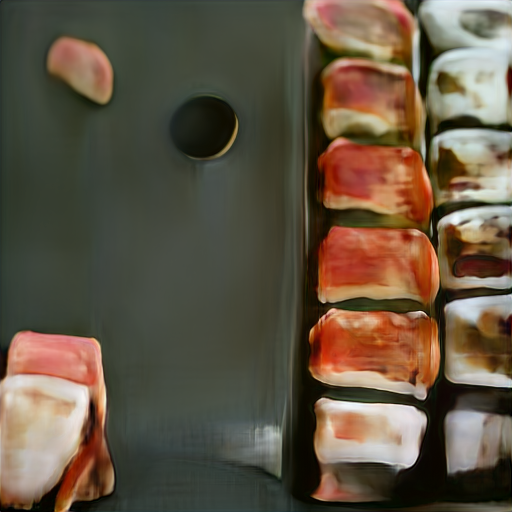

In [9]:
Image.fromarray(np.clip(((np.array( jnp.mean(r, axis=0))+1)*255/2),0,255).astype(np.uint8))

In [42]:
np.min(np.array( jnp.mean(img_orig, axis=0)))

-1.1015625

In [41]:
np.array(img_orig[17]).all() ==np.array(img_orig[0]).all()

True

In [ ]:
mean_latent

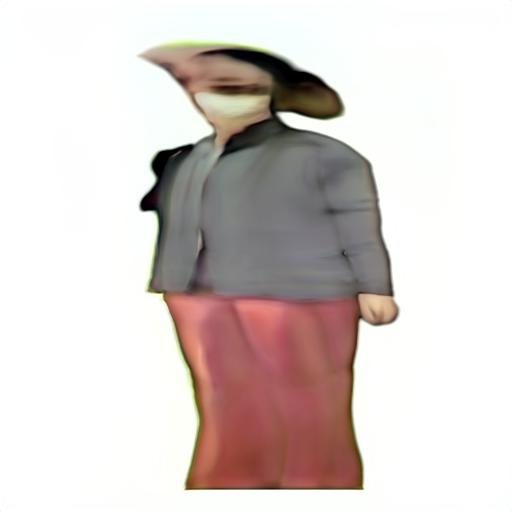

In [59]:
display(Image.open('results/00280.jpg'))

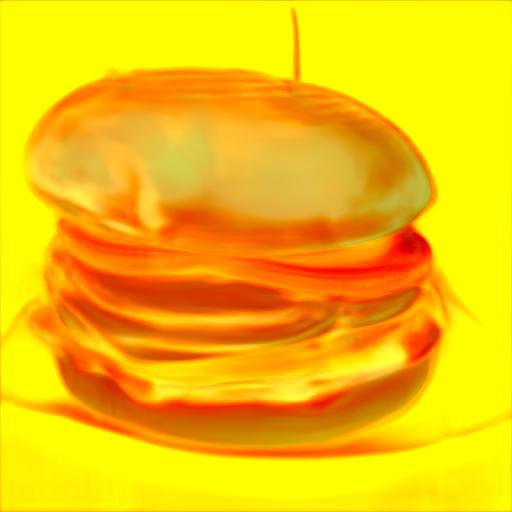

In [39]:
display(Image.open('results/00290.jpg'))


In [13]:
dir(G)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__dataclass_transform__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apply_fn',
 'apply_gradients',
 'apply_mapping',
 'apply_synthesis',
 'create',
 'dynamic_scale_main',
 'dynamic_scale_reg',
 'epoch',
 'moving_stats',
 'noise_consts',
 'opt_state',
 'params',
 'replace',
 'step',
 'tx']

(2, 512)
(2, 512)


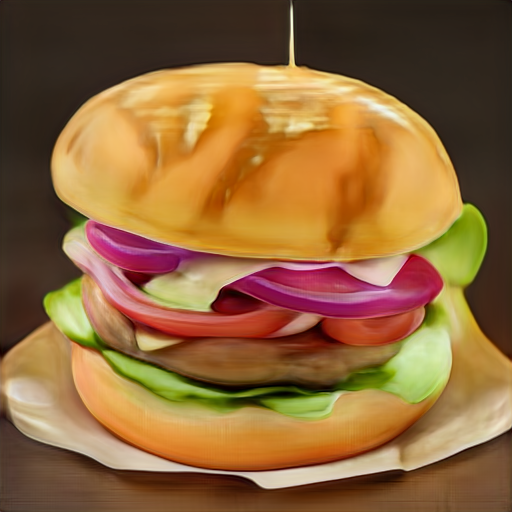

In [25]:
rng = jax.random.PRNGKey(100)
mean_latent = generator_mean_latent(G, 2, rng)
r=G.apply_synthesis({'params': G.params['synthesis'], 'moving_stats': G.moving_stats,'noise_consts': G.noise_consts},mean_latent, noise_mode='none')
Image.fromarray(np.clip(((np.array( jnp.mean(r, axis=0))+1)*255/2),0,255).astype(np.uint8))

In [41]:
dir(G)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__dataclass_transform__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apply_fn',
 'apply_gradients',
 'apply_mapping',
 'apply_synthesis',
 'create',
 'dynamic_scale_main',
 'dynamic_scale_reg',
 'epoch',
 'moving_stats',
 'noise_consts',
 'opt_state',
 'params',
 'replace',
 'step',
 'tx']

In [49]:
 dir(G.params['const'])

KeyError: 'const'

In [48]:
G['const']

TypeError: 'TrainStateG' object is not subscriptable

In [54]:
import jax
import jax.numpy as jnp
from jax import random

def mean_w(generator, num_points, rng_seed=0):
    rng = random.PRNGKey(rng_seed)
    z_points = random.normal(rng, (num_points, 512))
    w_points = generator.apply_mapping({'params': G.params['mapping'], 'moving_stats': G.moving_stats},z_points,train=False)
    mean_w = jnp.mean(w_points, axis=0)
    return mean_w

def generator_mean_latent(generator, n_latent, rng):
    latent_in = random.normal(rng, (n_latent, 512))

    latent = generator.apply_mapping({'params': G.params['mapping'], 'moving_stats': G.moving_stats},latent_in,c=jnp.array([[0,0,0,0,1],[0,0,0,0,1]]),train=False).mean(0, keepdims=True)
    return latent

# Usage:
# mapping_network: instance of your MappingNetwork class
# num_points: the number of random z points you want to use
mean_w_values = mean_w(G, num_points=100)

In [55]:
print(mean_w_values)

[[-0.01855275  0.03852232  0.11712539 ...  0.18033099 -0.05183438
   0.08605436]
 [-0.01855275  0.03852232  0.11712539 ...  0.18033099 -0.05183438
   0.08605436]
 [-0.01855275  0.03852232  0.11712539 ...  0.18033099 -0.05183438
   0.08605436]
 ...
 [-0.01855275  0.03852232  0.11712539 ...  0.18033099 -0.05183438
   0.08605436]
 [-0.01855275  0.03852232  0.11712539 ...  0.18033099 -0.05183438
   0.08605436]
 [-0.01855275  0.03852232  0.11712539 ...  0.18033099 -0.05183438
   0.08605436]]
